<a href="https://colab.research.google.com/github/Pramod858/Malaria-Cell-Image-Classification/blob/main/Malaria_Cell_Image_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import ibraries

In [1]:
import os
import random
import shutil
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import sklearn
from sklearn.metrics import confusion_matrix, roc_curve
import seaborn as sns
from google.colab import files
from PIL import Image
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.regularizers  import L2

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, roc_auc_score
from google.colab import drive

In [2]:
!pip install -q kaggle

In [3]:
# Upload your Kaggle API key file (kaggle.json)
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [4]:
! mkdir -p ~/.kaggle
! cp kaggle.json ~/.kaggle/

In [5]:
!chmod 600 ~/.kaggle/kaggle.json

## Download Dataset

In [6]:
!kaggle datasets download -d iarunava/cell-images-for-detecting-malaria

 97% 657M/675M [00:04<00:00, 193MB/s]
100% 675M/675M [00:04<00:00, 157MB/s]


In [7]:
# # To remove a folder
# import shutil
# folder_path = '/content/dataset'

# shutil.rmtree(folder_path)

In [8]:
# !mkdir -p "/content/dataset/"  # Create the target directory if it doesn't exist
!unzip -q "/content/cell-images-for-detecting-malaria.zip" -d "/content/dataset/"

In [9]:
for dirpath, dirnames, filenames in os.walk("dataset"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}")

There are 1 directories and 0 images in 'dataset
There are 3 directories and 0 images in 'dataset/cell_images
There are 0 directories and 13780 images in 'dataset/cell_images/Parasitized
There are 2 directories and 0 images in 'dataset/cell_images/cell_images
There are 0 directories and 13780 images in 'dataset/cell_images/cell_images/Parasitized
There are 0 directories and 13780 images in 'dataset/cell_images/cell_images/Uninfected
There are 0 directories and 13780 images in 'dataset/cell_images/Uninfected


In [10]:
parasitic_dir = "/content/dataset/cell_images/Parasitized"
uninfected_dir = "/content/dataset/cell_images/Uninfected"

In [11]:
def view_random_images(target_folder, num_images=16, grid_size=(4, 4)):
    # Get a list of random image paths
    random_images = random.sample(os.listdir(target_folder), num_images)

    # Create a grid for displaying the images
    fig, axes = plt.subplots(*grid_size, figsize=(10, 10))

    for i, ax in enumerate(axes.ravel()):
        if i < num_images:
            img_path = os.path.join(target_folder, random_images[i])
            img = mpimg.imread(img_path)
            ax.imshow(img)
            ax.axis("off")

    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.show()

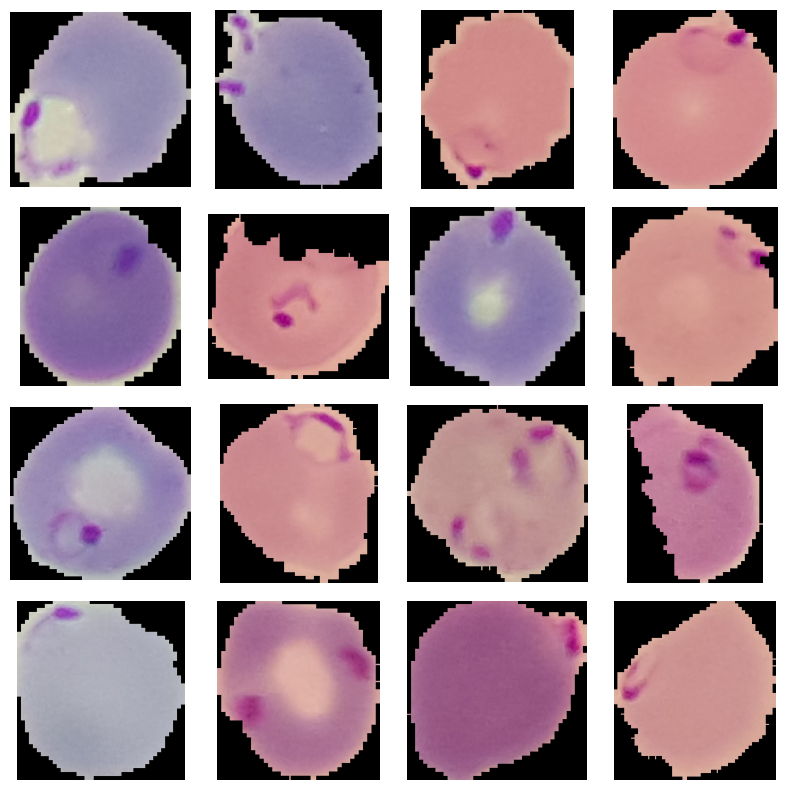

In [12]:
# View a random image from the training dataset
img = view_random_images(parasitic_dir)

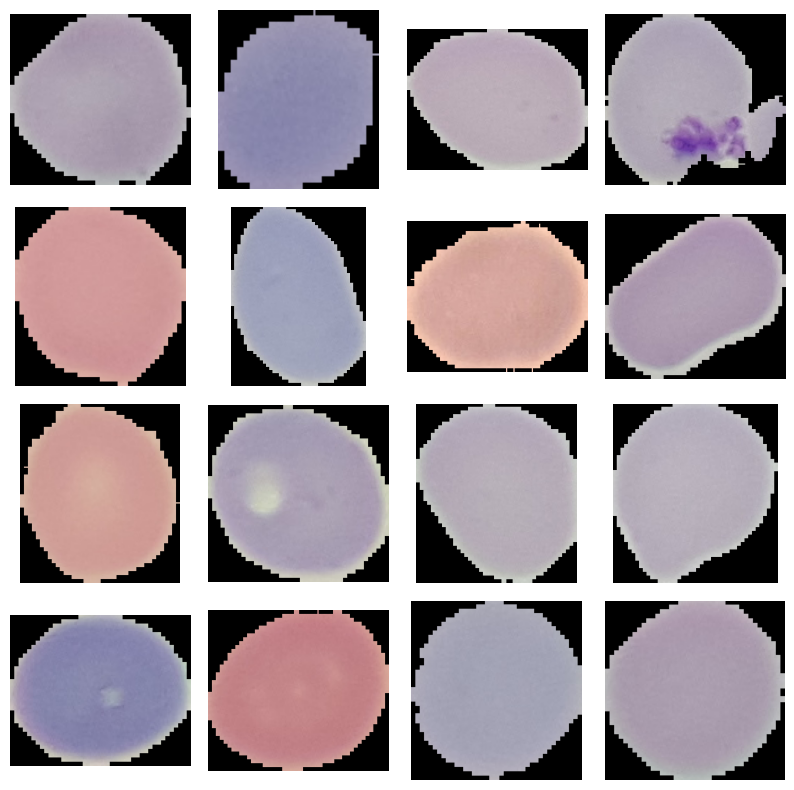

In [13]:
image = view_random_images(uninfected_dir)

In [14]:
# Define paths for the original data and destination folders
original_parasitized_path = "/content/dataset/cell_images/Parasitized"
original_uninfected_path = "/content/dataset/cell_images/Uninfected"

train_parasitized_path = "/content/Data/Train/Parasitized"
train_uninfected_path = "/content/Data/Train/Uninfected"

val_parasitized_path = "/content/Data/Validation/Parasitized"
val_uninfected_path = "/content/Data/Validation/Uninfected"

test_parasitized_path = "/content/Data/Test/Parasitized"
test_uninfected_path = "/content/Data/Test/Uninfected"

# Create the destination folders if they don't exist
os.makedirs(train_parasitized_path, exist_ok=True)
os.makedirs(val_parasitized_path, exist_ok=True)
os.makedirs(test_parasitized_path, exist_ok=True)
os.makedirs(train_uninfected_path, exist_ok=True)
os.makedirs(val_uninfected_path, exist_ok=True)
os.makedirs(test_uninfected_path, exist_ok=True)

# Load the list of parasitized and uninfected images
parasitized_images = os.listdir(original_parasitized_path)
uninfected_images = os.listdir(original_uninfected_path)

# Shuffle the image lists
random.shuffle(parasitized_images)
random.shuffle(uninfected_images)

# Split sizes for train, validation, and test (90% train, 0.5% validation,0.5% test)
parasitized_train_size = int(0.9 * len(parasitized_images))
parasitized_val_size = int(0.05 * len(parasitized_images))
parasitized_test_size = len(parasitized_images) - parasitized_train_size - parasitized_val_size

uninfected_train_size = int(0.9 * len(uninfected_images))
uninfected_val_size = int(0.05 * len(uninfected_images))
uninfected_test_size = len(uninfected_images) - uninfected_train_size - uninfected_val_size

# Move parasitized images to the train folder
for image in parasitized_images[:parasitized_train_size]:
    shutil.copyfile(os.path.join(original_parasitized_path, image), os.path.join(train_parasitized_path, image))

# Move parasitized images to the validation folder
for image in parasitized_images[parasitized_train_size:parasitized_train_size + parasitized_val_size]:
    shutil.copyfile(os.path.join(original_parasitized_path, image), os.path.join(val_parasitized_path, image))

# Move parasitized images to the test folder
for image in parasitized_images[parasitized_train_size + parasitized_val_size:]:
    shutil.copyfile(os.path.join(original_parasitized_path, image), os.path.join(test_parasitized_path, image))

# Move uninfected images to the train folder
for image in uninfected_images[:uninfected_train_size]:
    shutil.copyfile(os.path.join(original_uninfected_path, image), os.path.join(train_uninfected_path, image))

# Move uninfected images to the validation folder
for image in uninfected_images[uninfected_train_size:uninfected_train_size + uninfected_val_size]:
    shutil.copyfile(os.path.join(original_uninfected_path, image), os.path.join(val_uninfected_path, image))

# Move uninfected images to the test folder
for image in uninfected_images[uninfected_train_size + uninfected_val_size:]:
    shutil.copyfile(os.path.join(original_uninfected_path, image), os.path.join(test_uninfected_path, image))

In [15]:
for dirpath, dirnames, filenames in os.walk("Data"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}")

There are 3 directories and 0 images in 'Data
There are 2 directories and 0 images in 'Data/Validation
There are 0 directories and 689 images in 'Data/Validation/Parasitized
There are 0 directories and 689 images in 'Data/Validation/Uninfected
There are 2 directories and 0 images in 'Data/Test
There are 0 directories and 689 images in 'Data/Test/Parasitized
There are 0 directories and 689 images in 'Data/Test/Uninfected
There are 2 directories and 0 images in 'Data/Train
There are 0 directories and 12402 images in 'Data/Train/Parasitized
There are 0 directories and 12402 images in 'Data/Train/Uninfected


In [16]:
train_dir = "/content/Data/Train"
val_dir = "/content/Data/Validation"
test_dir = "/content/Data/Test"

## Data Preprocessing

### Data Augmentation

In [17]:
W = 128
H = 128

In [18]:
from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1/255.,
    rotation_range=20,        # Random rotation up to 20 degrees
    width_shift_range=0.1,    # Random horizontal shift of 10% of the image width
    height_shift_range=0.1,   # Random vertical shift of 10% of the image height
    shear_range=0.2,          # Shear transformation with maximum angle of 20 degrees
    zoom_range=0.2,           # Random zoom of up to 20%
    horizontal_flip=True,     # Randomly flip images horizontally
    fill_mode='nearest',      # Fill points outside the boundaries with the nearest pixel
    dtype='float64')

#on test, we do not augment, merely preprocess
val_datagen = ImageDataGenerator(rescale=1/255.,
                                  dtype='float64')

test_datagen = ImageDataGenerator(rescale=1/255.,
                                  dtype='float64')

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = (W,H),
    batch_size = 32,
    class_mode='binary',
    shuffle=True # Shuffle the data during training
    )

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size = (W,H),
    batch_size = 32,
    class_mode = 'binary',
    shuffle=False # No need to shuffle the test data
    )

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size = (W,H),
    batch_size = 32,
    class_mode = 'binary',
    shuffle=False # No need to shuffle the test data
    )


Found 24802 images belonging to 2 classes.
Found 1378 images belonging to 2 classes.
Found 1378 images belonging to 2 classes.


Augmented image label: Parasitized


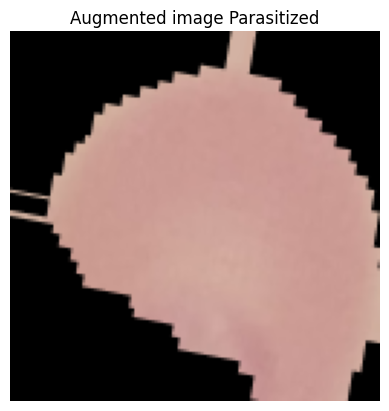

In [19]:
augmented_images, augmented_labels = train_generator.next()  # Note: labels aren't augmented, they stay the same
random_number = random.randint(0, 32)  # we're making batches of size 32, so we'll get a random instance

# Get the class names from the generator
class_names = list(train_generator.class_indices.keys())

# Get the label index of the augmented image
label_index = np.argmax(augmented_labels[random_number])

# Get the class name corresponding to the label index
class_name = class_names[label_index]

print(f"Augmented image label: {class_name}")
plt.figure()
plt.imshow(augmented_images[random_number])
plt.title(f"Augmented image {class_name}")
plt.axis(False)
plt.show()

In [20]:
# Get the class names from the generator
class_names = list(train_generator.class_indices.keys())
class_names

['Parasitized', 'Uninfected']

In [21]:
model1 = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(H, W, 3)),
    MaxPooling2D((2, 2)),
    BatchNormalization(axis=-1),
    Dropout(0.2),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    BatchNormalization(axis=-1),
    Dropout(0.2),

    Flatten(),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')
])

In [22]:
model1.compile(optimizer=tf.keras.optimizers.Adam(0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])


model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 32)        0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 63, 63, 32)        128       
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 63, 63, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 30, 30, 64)        0

In [23]:
epochs = 20
history = model1.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs
)

Epoch 1/20
776/776 [==============================] - 149s 176ms/step - loss: 0.7652 - accuracy: 0.6474 - val_loss: 0.6351 - val_accuracy: 0.6401
Epoch 2/20
776/776 [==============================] - 136s 175ms/step - loss: 0.5378 - accuracy: 0.7515 - val_loss: 0.3399 - val_accuracy: 0.8636
Epoch 3/20
776/776 [==============================] - 134s 172ms/step - loss: 0.3509 - accuracy: 0.8565 - val_loss: 0.3191 - val_accuracy: 0.8781
Epoch 4/20
776/776 [==============================] - 135s 174ms/step - loss: 0.2795 - accuracy: 0.8949 - val_loss: 0.7638 - val_accuracy: 0.7598
Epoch 5/20
776/776 [==============================] - 132s 171ms/step - loss: 0.2539 - accuracy: 0.9034 - val_loss: 0.2657 - val_accuracy: 0.9064
Epoch 6/20
776/776 [==============================] - 135s 173ms/step - loss: 0.2427 - accuracy: 0.9087 - val_loss: 0.1704 - val_accuracy: 0.9390
Epoch 7/20
776/776 [==============================] - 132s 170ms/step - loss: 0.2265 - accuracy: 0.9151 - val_loss: 0.2103 -

In [24]:
test_loss, test_accuracy = model1.evaluate(test_generator)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

44/44 [==============================] - 2s 40ms/step - loss: 0.1757 - accuracy: 0.9296
Test Loss: 0.17570167779922485
Test Accuracy: 0.9296081066131592


<ipython-input-25-50c983d73b0d>:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


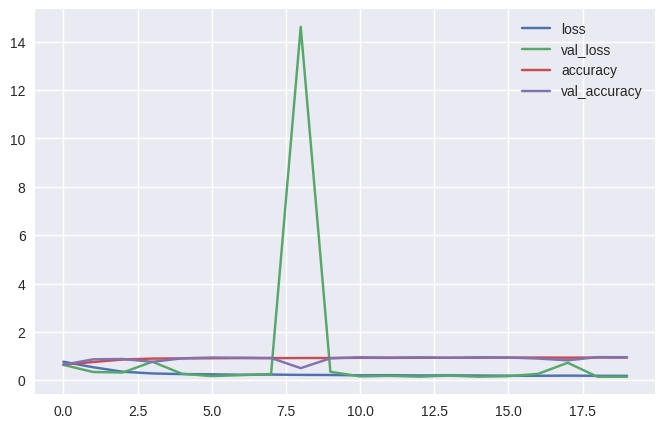

In [25]:
epochs = range(len(history.history['loss']))
plt.figure(figsize=(8,5))
plt.style.use("seaborn")
plt.plot(epochs, history.history['loss'], label = 'loss')
plt.plot(epochs, history.history['val_loss'], label = 'val_loss')
plt.plot(epochs, history.history['accuracy'], label = 'accuracy')
plt.plot(epochs, history.history['val_accuracy'], label = 'val_accuracy')
plt.legend()
plt.show()

##Building Model Using VGG16

In [26]:
base_model = VGG16(
    weights='imagenet',
    input_shape=(128,128,3),
    include_top=False)


58889256/58889256 [==============================] - 0s 0us/step


In [27]:
base_model.trainable = True

In [28]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.2)(x)
x = Dense(512, activation='relu', kernel_regularizer=L2(0.01))(x)
x = BatchNormalization(axis=-1)(x)
x = Dropout(0.2)(x)

outputs = Dense(1, activation="sigmoid")(x)

fine_tune_model = Model(inputs=base_model.input, outputs=outputs)

In [29]:
fine_tune_model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='binary_crossentropy',
              metrics=['accuracy'])

fine_tune_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0     

In [30]:
file_path = '/content/drive/MyDrive/Malaria_Project/Models/fine_tune_model.h5'

cp = ModelCheckpoint(
    filepath=file_path,
    verbose=1,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True
)

early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=5,
    mode='min',
    verbose=1
)

In [31]:
epochs = 20
fine_tune_history = fine_tune_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs,
    callbacks=[cp,early_stopping_callback],
    verbose=1
)

Epoch 1/20
776/776 [==============================] - ETA: 0s - loss: 4.8534 - accuracy: 0.9237
Epoch 1: val_accuracy improved from -inf to 0.96662, saving model to /content/drive/MyDrive/Malaria_Project/Models/fine_tune_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


776/776 [==============================] - 177s 214ms/step - loss: 4.8534 - accuracy: 0.9237 - val_loss: 4.2801 - val_accuracy: 0.9666
Epoch 2/20
776/776 [==============================] - ETA: 0s - loss: 3.9106 - accuracy: 0.9500
Epoch 2: val_accuracy improved from 0.96662 to 0.96952, saving model to /content/drive/MyDrive/Malaria_Project/Models/fine_tune_model.h5
776/776 [==============================] - 171s 220ms/step - loss: 3.9106 - accuracy: 0.9500 - val_loss: 3.4556 - val_accuracy: 0.9695
Epoch 3/20
776/776 [==============================] - ETA: 0s - loss: 3.1482 - accuracy: 0.9542
Epoch 3: val_accuracy improved from 0.96952 to 0.97025, saving model to /content/drive/MyDrive/Malaria_Project/Models/fine_tune_model.h5
776/776 [==============================] - 172s 222ms/step - loss: 3.1482 - accuracy: 0.9542 - val_loss: 2.7683 - val_accuracy: 0.9702
Epoch 4/20
776/776 [==============================] - ETA: 0s - loss: 2.5138 - accuracy: 0.9573
Epoch 4: val_accuracy improved fr

In [32]:
test_loss, test_accuracy = fine_tune_model.evaluate(test_generator)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

44/44 [==============================] - 2s 49ms/step - loss: 0.2570 - accuracy: 0.9724
Test Loss: 0.25700417160987854
Test Accuracy: 0.972423791885376


<ipython-input-33-d700454f0413>:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


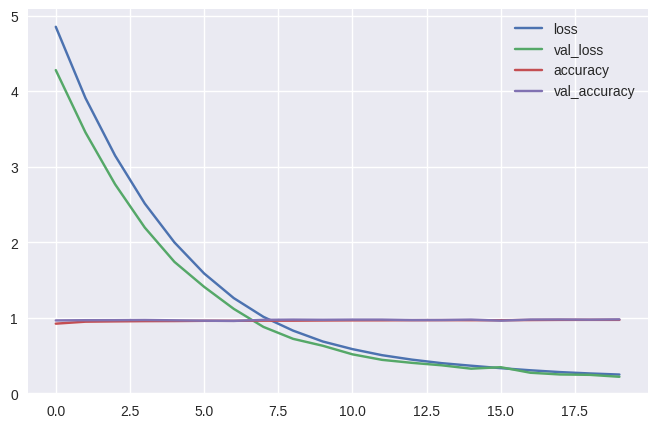

In [33]:
plt.style.use("seaborn")
plt.figure(figsize=(8,5))
plt.plot(fine_tune_history.history['loss'], label = 'loss')
plt.plot(fine_tune_history.history['val_loss'], label = 'val_loss')
plt.plot(fine_tune_history.history['accuracy'], label = 'accuracy')
plt.plot(fine_tune_history.history['val_accuracy'], label = 'val_accuracy')
plt.legend()
plt.show()

In [34]:
# Finding the labels of the test data
true_labels = test_generator.classes
true_labels[:200]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0], dtype=int32)

##Prediction

### Confusion Matrix

#### Model1 Confusion Matrix

In [35]:
predicted_probabilities_model1 = model1.predict(test_generator)

44/44 [==============================] - 2s 48ms/step


In [36]:
# Get the predicted classes (0 or 1)
predicted_classes_model1 = (predicted_probabilities_model1 > 0.5).astype(int)

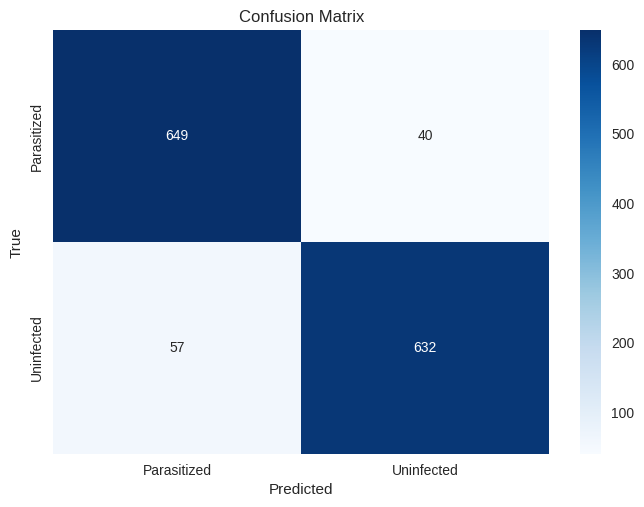

In [37]:
# Create a confusion matrix
cm = confusion_matrix(true_labels, predicted_classes_model1)

# Plot the confusion matrix
plt.figure()
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

#### Fine Tuned Model Confusion Matrix

In [38]:
predicted_probabilities_fine_tuned = fine_tune_model.predict(test_generator)

44/44 [==============================] - 2s 48ms/step


In [39]:
# Get the predicted classes (0 or 1)
predicted_classes_fine_tuned = (predicted_probabilities_fine_tuned > 0.5).astype(int)

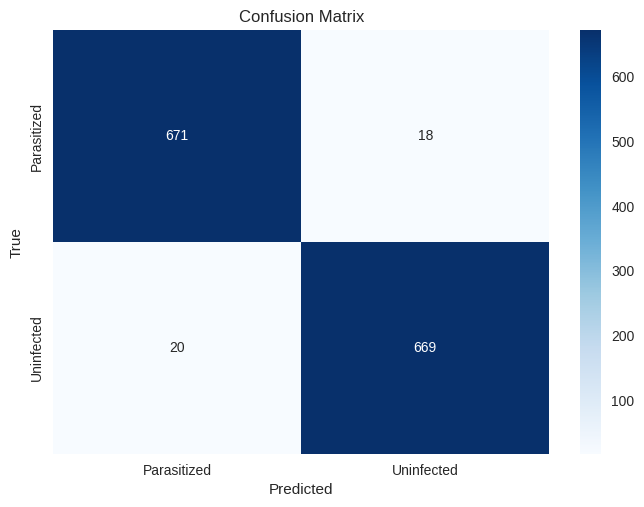

In [40]:
# Create a confusion matrix
cm = confusion_matrix(true_labels, predicted_classes_fine_tuned)

# Plot the confusion matrix
plt.figure()
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [41]:
def multiple_metrics(true_labels, predicted_classes, predicted_probabilities=None):
    # Calculate various performance metrics
    accuracy = accuracy_score(true_labels, predicted_classes)
    precision = precision_score(true_labels, predicted_classes)
    recall = recall_score(true_labels, predicted_classes)
    f1 = f1_score(true_labels, predicted_classes)

    # Calculate ROC AUC score if predicted_probabilities is provided
    roc_auc = None
    if predicted_probabilities is not None and predicted_probabilities.shape[1] == 1:
        roc_auc = roc_auc_score(true_labels, predicted_probabilities)  # Assuming you're calculating for the positive class

    # Create a dictionary to hold the metrics
    metrics = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'ROC AUC Score': roc_auc
    }

    return metrics

In [42]:
# Calculate metrics for the initial model
model1_metrics = multiple_metrics(true_labels, predicted_classes_model1,predicted_probabilities_model1)

# Calculate metrics for the initial model
fine_tune_metrics = multiple_metrics(true_labels, predicted_classes_fine_tuned,predicted_probabilities_fine_tuned)

In [43]:
# Create a DataFrame to compare the metrics
metrics_df = pd.DataFrame([model1_metrics,fine_tune_metrics], index=['Model1','Fine-Tuned Model'])

# Print the DataFrame
metrics_df

,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
Model1,0.929608,0.940476,0.917271,0.928729,0.981888
Fine-Tuned Model,0.972424,0.973799,0.970972,0.972384,0.994550
